Diffusion Models - Live Coding Tutorial
url: https://www.youtube.com/watch?v=S_il77Ttrmg

In [11]:
"""
mean = sqrt(a_hat_t) * x_0)
variance = sqrt(1 - a_hat_t) * random_noise
"""
import torch

x0 = torch.randn(2, 3, 32, 32) 
betas = torch.tensor([0.05, 0.1, 0.15, 0.2, 0.25])
t = torch.tensor([1, 3])

# betas -> количество шума, которое применяется на каждом шаге процесса диффузии
# alphas -> 1 - betas -> количество информации об исходном изображении, сохраняемое после процесса диффузии

alphas = 1 - betas

alpha_hat = torch.cumprod(alphas, axis = 0)
print(alphas)
print(alpha_hat)
print(alpha_hat.size())
result = alpha_hat.gather(-1, t).reshape(-1, 1, 1, 1)
print(result)
print(result.size())

noise = torch.rand_like(x0)
mean = result.sqrt() * x0
variance = torch.sqrt(1 - result) * noise

x_t = mean + variance
x_t.size()

tensor([0.9500, 0.9000, 0.8500, 0.8000, 0.7500])
tensor([0.9500, 0.8550, 0.7268, 0.5814, 0.4360])
torch.Size([5])
tensor([[[[0.8550]]],


        [[[0.5814]]]])
torch.Size([2, 1, 1, 1])


torch.Size([2, 3, 32, 32])

In [24]:
def forward_diffusion(x0: torch.Tensor, t: torch.Tensor, betas: torch.Tensor = torch.linspace(0.0, 1.0, 5)) -> torch.Tensor:
    """
    Применяет процесс диффузии к тензору `x0` на заданных временных шагах `t`.

    Аргументы:
    - x0 (torch.Tensor): Исходный тензор размерности (N, C, H, W).
    - t (torch.Tensor): Тензор временных шагов размерности (M,).
    - betas (torch.Tensor, по умолчанию=torch.linspace(0.0, 1.0, 5)): Тензор коэффициентов шума размерности (K,).

    Возвращает:
    - torch.Tensor: Результат процесса диффузии размерности (M, K, N, C, H, W).

    Функция применяет процесс диффузии к исходному тензору `x0`, где каждый пиксель на каждом временном шаге
    умножается на соответствующий коэффициент шума из тензора `betas`. Результат процесса диффузии возвращается в виде тензора.

    Пример использования:
    >>> x0 = torch.randn(2, 3, 32, 32)
    >>> t = torch.tensor([1, 3])
    >>> betas = torch.tensor([0.05, 0.1, 0.15, 0.2, 0.25])
    >>> result = forward_diffusion(x0, t, betas)
    """
    noise = torch.rand_like(x0) # Случайный тензор со значениями из N(0, 1)
    alphas = 1 - betas
    alpha_hat = torch.cumprod(alphas, axis = 0)
    alpha_hat_t = alpha_hat.gather(-1, t).reshape(-1, 1, 1, 1)

    mean = alpha_hat_t.sqrt() * x0
    variance = torch.sqrt(1 - alpha_hat_t) * noise
    return mean + variance, noise

In [15]:
from torchvision.datasets import MNIST

# Загрузка тренировочного набора
train_dataset = MNIST(root='data/', train=True, transform=None, download=True)

#Загрузка тестового набора данных
test_dataset = MNIST(root='data/', train=False, transform=None, download = True)

#Получение данных из тренировочного набора
train_data = train_dataset.data
train_labels = train_dataset.targets

#Получение данных из тестового набора
test_data = test_dataset.data
test_labels = test_dataset.targets

print(train_data.shape)

torch.Size([60000, 28, 28])


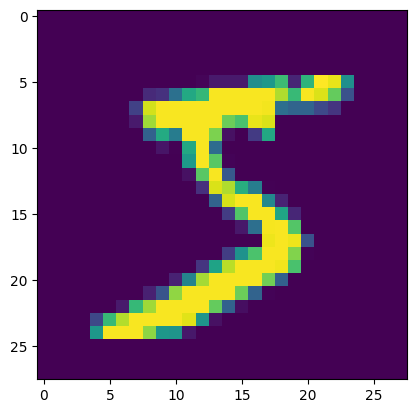

In [33]:
import torchvision.transforms as transforms

#Приведение данных к диапазону от 0 до 1
train_data = train_dataset.data.float() / 255.0
test_data = test_dataset.data.float() / 255.0

import matplotlib.pyplot as plt

plt.imshow(train_data[0])
plt.show()

In [50]:
t = torch.tensor([0, 1, 2, 3, 4])
noisy_images, _ = forward_diffusion(train_data[0], t)

In [43]:
noisy_images[0].size()

torch.Size([3, 28, 28])

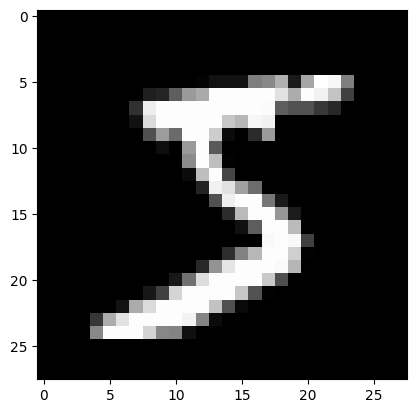

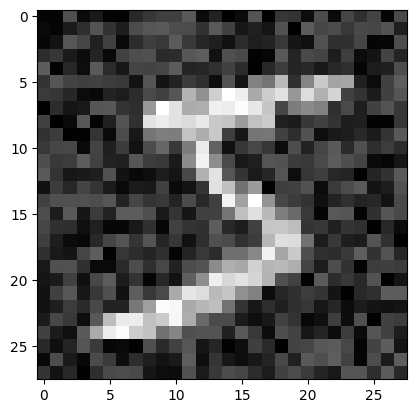

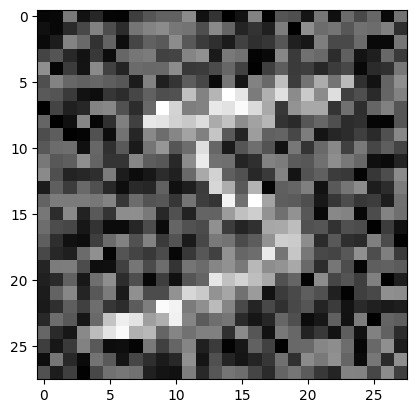

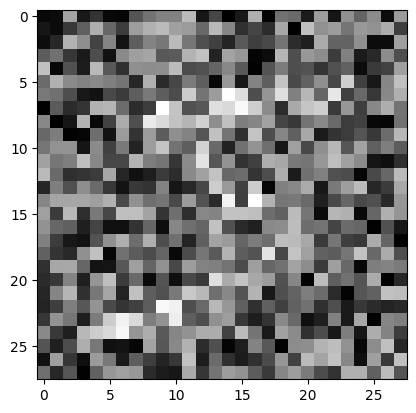

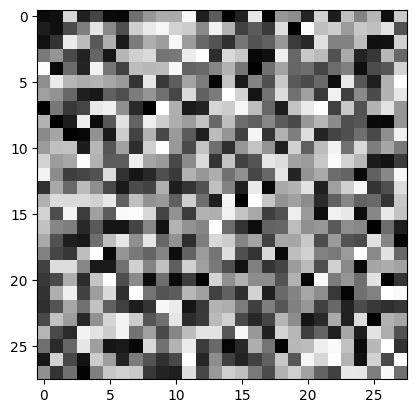

In [52]:
for img in noisy_images:
    img = img.permute(1, 2, 0).squeeze()

    plt.imshow(img, cmap='gray')
    plt.show()